# 1. High-level interface

The `h5rdmtoolbox` wraps additional features around the `h5py` package such that the core functionalities are untouched and syntax is mostly the same.

In [1]:
import h5rdmtoolbox as h5tbx

h5tbx.__version__

Failed to import module h5tbx


'1.3.0'

## 1.1 File creation

Note: A filename must not be given! It is generated temporarily in the users local tmp directory. Great for testing and playing around:

In [2]:
with h5tbx.File() as h5:
    h5.create_dataset(name='my_dataset', data=4.3)

In addition to `filename`, `hdf_filename` is provided as a `pathlib` object, which can also be accessed if the file is closed.

In [3]:
h5.hdf_filename

WindowsPath('C:/Users/Matthias/AppData/Local/h5rdmtoolbox/h5rdmtoolbox/tmp/tmp_0/tmp0.hdf')

## 1.2 Group and dataset creation
Attributes can be passed alongside with the creation methods:

In [4]:
with h5tbx.File(attrs={'comment': 'this is my favorite file'}) as h5:
    h5.create_group('measurement_data', attrs={'comment': 'measurement data of my experiment'})
    h5.create_dataset(name='my_dataset', data=4.3, attrs=dict(units='m/s'))

## 1.3 Dumping file content

In [5]:
h5tbx.dump(h5.hdf_filename, collapsed=False)

## 1.4 Special dataset creation from various sources

The advantage of allowing attributes to be passed during group and dataset creation is that we can write a data reader.

There various special methods implemented, such as:
- `create_dataset_from_csv`
- `create_datasets_from_csv`
- `create_dataset_from_image`
- `create_dataset_from_xarray_dataset`
- `create_from_dict`
- `create_from_yaml`
- `create_from_jsonld`

In [6]:
with h5tbx.File() as h5:
    h5.create_from_yaml('data.yaml')
    h5.dump(False)

## 1.5 Natural naming

If natural naming is enabled and datasets/groups have no spaces, they can be addressed like this:

In [7]:
with h5tbx.File(h5.hdf_filename) as h5:
    vel = h5.grp.subgrp.velocity
    print(vel)

<HDF5 dataset "velocity": shape (2,), type "<f8", convention "h5py">


Note, that this behaviour can be switched off:

In [8]:
with h5tbx.set_config(natural_naming=False):
    with h5tbx.File(h5.hdf_filename) as h5:
        try:
            vel = h5.grp.subgrp.velocity
        except AttributeError as e:
            print(e)

'File' object has no attribute 'grp'


# 2. Data exchange through xarray

A more "natral" way of exchanging data between HDF5 and users is by `xarray` rather than `numpy` as dimensions (coordinates) and attributes can be passed, too:

In [9]:
import numpy as np

In [10]:
with h5tbx.File() as h5:
    h5.create_dataset('y', np.linspace(0, 42, 34),
                      attrs={'units': 'm'},
                      make_scale=True)
    h5.create_dataset('x', np.linspace(-50, 100, 119),
                      attrs={'units': 'm'},
                      make_scale=True)
    h5.create_dataset('time', np.linspace(0, 1, 10), make_scale=True,
                     attrs={'units': 'min', 'long_name': 'Time since start'})
    h5.create_dataset(name='u',
                      data=np.random.random((10, 34, 119)),
                      attrs={'units': 'm/s'},
                      attach_scale=('time', 'y', 'x'))

## 2.1 Retrieving xarray data

In [11]:
with h5tbx.File(h5.hdf_filename) as h5:
    u = h5.u[..., 0]
u

<xarray.DataArray 'u' (time: 10, y: 34)>
0.04073 0.4662 0.864 0.6451 0.5832 0.413 ... 0.7149 0.3676 0.6276 0.8222 0.4139
Coordinates:
  * time     (time) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * y        (y) float64 0.0 1.273 2.545 3.818 5.091 ... 38.18 39.45 40.73 42.0
    x        float64 -50.0
Attributes:
    units:    m/s

## 2.2 Retrieving numpy data
It is still possible to return numpy array data by calling property `.values`

In [12]:
with h5tbx.File(h5.hdf_filename) as h5:
    u_np = h5.u.values[()]
u_np

array([[[0.04072649, 0.27280133, 0.94754082, ..., 0.78441504,
         0.21851153, 0.08799241],
        [0.46623954, 0.8089874 , 0.97677981, ..., 0.93723353,
         0.80277807, 0.58627118],
        [0.86395017, 0.68896067, 0.46063939, ..., 0.99427433,
         0.46038925, 0.35791322],
        ...,
        [0.22807513, 0.0291764 , 0.43484351, ..., 0.74195837,
         0.88025281, 0.55259135],
        [0.49765837, 0.77656084, 0.90266594, ..., 0.21273699,
         0.59859601, 0.81417719],
        [0.05374612, 0.57535975, 0.17125633, ..., 0.19630591,
         0.84477488, 0.84486377]],

       [[0.37890693, 0.55279216, 0.67837271, ..., 0.28610804,
         0.2721225 , 0.13873941],
        [0.47203252, 0.87195565, 0.39179953, ..., 0.34980415,
         0.38990958, 0.708474  ],
        [0.88494893, 0.35559567, 0.49467462, ..., 0.41983251,
         0.4900213 , 0.52001398],
        ...,
        [0.92998765, 0.24763116, 0.45680261, ..., 0.21453173,
         0.16244762, 0.77640139],
        [0.5

### 2.3 Assigning xarray data

**Wise versa**, datasets can be created from `xarray` objects, too:

In [13]:
with h5tbx.File() as h5:
    h5.create_dataset('u_loaded', data=u)
    h5.dump(False)

### 2.4 Other implications by interfacing with `xarray`

#### 2.4.1 Plotting

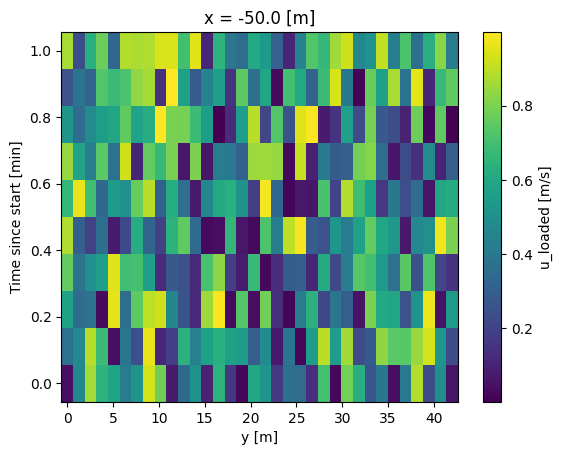

In [14]:
u[()].plot()

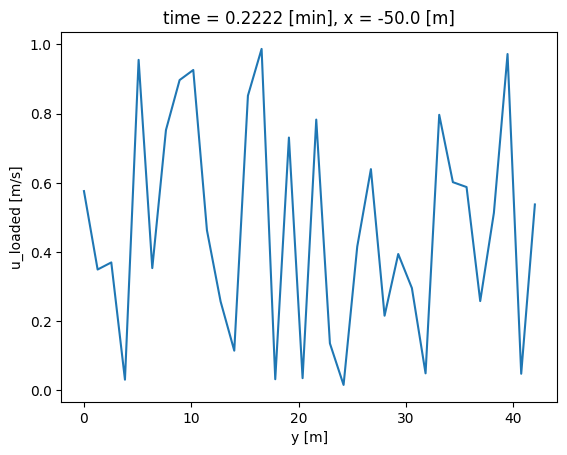

In [15]:
u[2, :].plot()

#### 2.4.2 Indexing and selecting data

See `xarray`'s documentation for in-depth explanations (https://docs.xarray.dev/en/latest/user-guide/indexing.html).

"Xarray offers extremely flexible indexing routines that combine the best features of NumPy and pandas for data selection."

In [16]:
u.coords

Coordinates:
  * time     (time) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * y        (y) float64 0.0 1.273 2.545 3.818 5.091 ... 38.18 39.45 40.73 42.0
    x        float64 -50.0

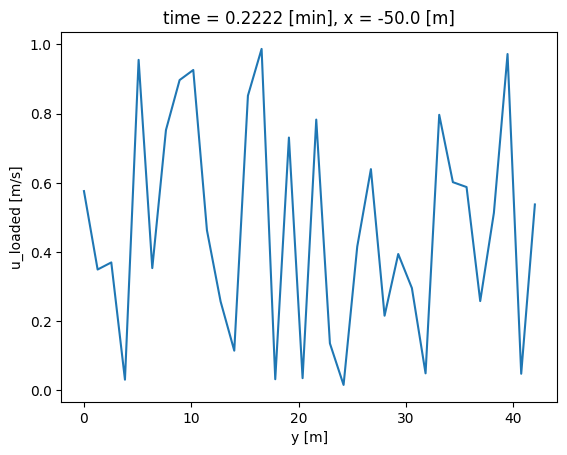

In [17]:
u.isel(time=2).plot()

The toolbox offers the mechanism at file level, too:

In [18]:
with h5tbx.File(h5.hdf_filename) as h5:
    u03_isel = h5.u_loaded.isel(time=0, y=3)
u03_isel

<xarray.DataArray 'u_loaded' ()>
0.6451
Coordinates:
    time     float64 0.0
    y        float64 3.818
    x        float64 -50.0
Attributes:
    units:    m/s

In [19]:
with h5tbx.File(h5.hdf_filename) as h5:
    u03_sel = h5.u_loaded.sel(time=0, y=3, method='nearest')
u03_sel

<xarray.DataArray 'u_loaded' ()>
0.864
Coordinates:
    time     float64 0.0
    y        float64 2.545
    x        float64 -50.0
Attributes:
    units:    m/s

C:\Users\Matthias\Documents\programming\GitHub\h5RDMtoolbox\h5rdmtoolbox\wrapper\core.py:1654: UserWarning: Only ascending order is supported for np.ndarray and list. Reducing the data to unique values
  warnings.warn(


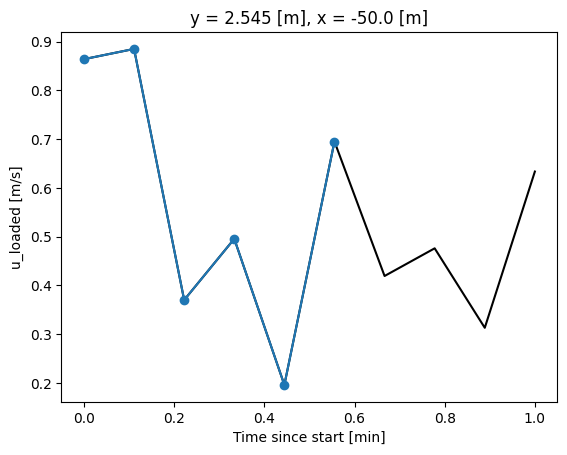

In [20]:
with h5tbx.File(h5.hdf_filename) as h5:
    u_full = h5.u_loaded.sel(y=3, method='nearest')
    u_sub_nearest = h5.u_loaded.sel(time=np.arange(0.05, 0.53, 0.02), y=3, method='nearest')
u_full.plot(color='k')
u_sub_nearest.plot(marker='o')

In [21]:
with h5tbx.File(h5.hdf_filename) as h5:
    u_sub = h5['u_loaded'].isel(y=h5['u_loaded'].y>5.3, time=h5['u_loaded'].time<0.5)
    u_full = h5['u_loaded'][()]

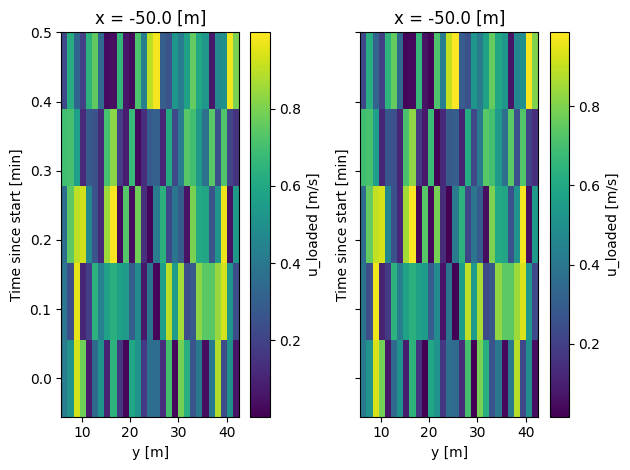

In [22]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True)
u_full.plot(ylim=[0, 3], ax=axs[0])
u_sub.plot(ax=axs[1])

# 2.5 Working with units

In [23]:
with h5tbx.File() as h5:
    h5.create_dataset(name='vel',
                      data=np.random.random((3, 100, 50)),
                      attrs=dict(units='m/s'))
    v = h5.vel.to_units('cm/s')[()]

In [24]:
v

<xarray.DataArray 'vel' (dim_0: 3, dim_1: 100, dim_2: 50)>
71.48 22.27 90.69 93.2 76.24 24.75 64.2 ... 38.26 2.256 23.21 24.5 68.6 37.4
Dimensions without coordinates: dim_0, dim_1, dim_2
Attributes:
    units:    cm/s